# Transformer Model

Model based on the following references:
  * [Detection-Transformer](https://github.com/AarohiSingla/Detection-Transformer/tree/main)
  * [Using Custom Datasets to train DETR for object detection](https://medium.com/@soumyajitdatta123/using-custom-datasets-to-train-detr-for-object-detection-75a6426b3f4e)

## Imports

In [3]:
# Add Utils to path
import sys
sys.path.append('../Utils')  # Adds higher directory to python modules path.

# Utils
from datasets_generators import CocoDetection

# Pytorch
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import DetrImageProcessor
from transformers import DetrForObjectDetection

## Dataset

In [4]:
# Paths
imgs_path = "../ExDark_All/Images"
train_path = "../ExDark_COCO/train_set.json"
val_path = "../ExDark_COCO/val_set.json"
test_path = "../ExDark_COCO/test_set.json"

# Transforms
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# COCO Dataset
train_set = CocoDetection(image_directory_path=imgs_path,  annotation_file_path=train_path, image_processor=image_processor)
val_set = CocoDetection(image_directory_path=imgs_path,  annotation_file_path=val_path, image_processor=image_processor)
test_set = CocoDetection(image_directory_path=imgs_path,  annotation_file_path=test_path, image_processor=image_processor)

# Collade function
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

# Labels
id2label = {k: v["name"] for k, v in train_set.coco.cats.items()}

# DataLoaders
TRAIN_DATALOADER = DataLoader(dataset=train_set, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=val_set, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=test_set, collate_fn=collate_fn, batch_size=4)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## Model

In [5]:
class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50", 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [4]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [5]:
batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

## Train

In [6]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 100

trainer = Trainer(devices=1, accelerator="cpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\ignac\anaconda3\envs\dl_finalproject\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.018   Total estimated model par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\ignac\anaconda3\envs\dl_finalproject\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\ignac\anaconda3\envs\dl_finalproject\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\ignac\anaconda3\envs\dl_finalproject\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\ignac\anaconda3\envs\dl_finalproject\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Plot Results

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at ./lightning_logs/version_0 and are newly initialized: ['bbox_predictor.layers.1.weight', 'bbox_predictor.layers.0.bias', 'class_labels_classifier.bias', 'bbox_predictor.layers.1.bias', 'bbox_predictor.layers.0.weight', 'class_labels_classifier.weight', 'bbox_predictor.layers.2.weight', 'bbox_predictor.layers.2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image ID:  0 Image:  2015_05520.JPEG

Annotations: 
{'id': 0, 'image_id': 0, 'category_id': 8, 'bbox': ['38', '355', '329', '90'], 'area': 29610.0} Category Label:  Dog
{'id': 1, 'image_id': 0, 'category_id': 10, 'bbox': ['120', '298', '161', '61'], 'area': 9821.0} Category Label:  People


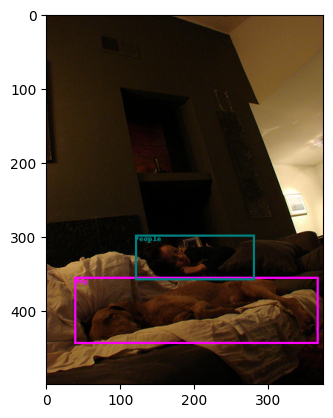

tensor(3)


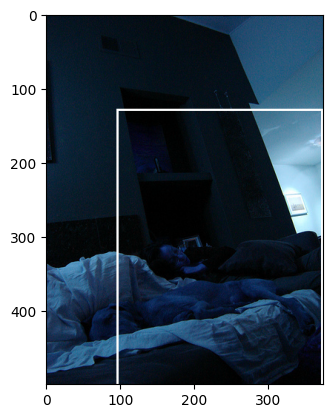

In [35]:
MODEL_PATH = './lightning_logs/version_0'
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)

import supervision as sv
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from plot_coco_image import plot_coco_image
from PIL import Image, ImageDraw
import cv2

# Get Image
image_ids = test_set.coco.getImgIds()
image_id = random.choice(image_ids)
image = test_set.coco.loadImgs(image_id)[0]

# Load Image
img_path = os.path.join(imgs_path, image["file_name"])
image = cv2.imread(img_path)

# Plor Ground Truth
plot_coco_image(coco_dataset=test_set, imgs_path = "../ExDark_All/Images", image_id=image_id)

# Predict
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt')
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]])
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=0.001, 
        target_sizes=target_sizes
    )[0]

    # Keep best predictions
    max_id = np.argmax(results["scores"])
    label = results['labels'][max_id]
    print(label)
    box = np.array(results["boxes"][max_id].unsqueeze(0))[0]
    bbox = [int(b) for b in box]
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    draw.rectangle([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]], width=3)
    plt.imshow(image)
    plt.show()
    